# Setup and data download

In [4]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import yahooquery as yq
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import tqdm
sns.set_style("whitegrid")
DARK_COL = "#6876a4"
LIGHT_COL = "#f0b64d"

In [5]:
######### Load fama french data ###########
ff = pd.read_csv("./data/F-F_Research_Data_5_Factors_2x3_daily.csv")
ff = ff.rename({"Unnamed: 0": "Date"}, axis = 1)
ff["Date"] = pd.to_datetime(ff["Date"], format="ISO8601")
ff

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1,1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
4,1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...,...
15036,2023-03-27,0.27,0.51,1.02,-0.28,0.35,0.016
15037,2023-03-28,-0.17,-0.03,0.74,0.08,0.55,0.016
15038,2023-03-29,1.39,-0.34,-0.50,-0.90,-0.54,0.016
15039,2023-03-30,0.51,-0.61,-0.59,0.20,-0.09,0.016


In [6]:
######### Get returns of S&P 500 stocks ###########

# Get tickers of S&P 500
def list_wikipedia_sp500() -> pd.DataFrame:
    # Ref: https://stackoverflow.com/a/75845569/
    url = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies'
    return pd.read_html(url, attrs={'id': 'constituents'}, index_col='Symbol')[0]

tickers = list(list_wikipedia_sp500().index) + ["^GSPC"]

# Download data from 2010 onwards up to last day of FF
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 4, 1) # Last day of FF
data = yf.download(tickers, start = start, end = end)
prices = data["Adj Close"].reset_index()
# Drop columns without any data
prices = prices.drop(["BF.B", "BRK.B", "HON"], axis=1)

# Compute log-prices and log-returns
returns = prices.copy()
returns.iloc[:,1:] = np.log(prices.iloc[:,1:])
Returns = np.diff(returns.iloc[:,1:],axis=0)*100  #times 100 so we get returns in percentage 
# We assume the first return to be 0
Returns = np.vstack((np.zeros(Returns.shape[1]),Returns))
returns.iloc[:,1:] = Returns
# Isolate S&P 500
sp500 = returns[["Date","^GSPC"]]
returns = returns.drop("^GSPC", axis = 1)
returns

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,-1.092166,10.724563,-0.596149,0.172770,NaN,-0.716046,-0.811195,-0.334110,0.616135,...,5.904167,-1.193060,0.389701,-1.195930,NaN,-0.342586,3.116528,-0.174548,3.465158,NaN
2,2010-01-06,-0.355955,-4.231411,0.868152,-1.603434,NaN,-0.950013,0.553758,-0.433244,1.057452,...,-1.320423,0.191861,0.860535,0.656664,NaN,-0.717446,-0.032290,-0.771667,8.338131,NaN
3,2010-01-07,-0.129771,2.904340,-0.024734,-0.185038,NaN,-1.616682,0.825047,-0.589966,-0.093530,...,2.113132,-0.432173,-0.314650,1.300615,NaN,-0.028801,2.268099,-2.531778,10.616022,NaN
4,2010-01-08,-0.032452,-1.926821,0.394523,0.662638,NaN,1.080681,0.509911,-0.197437,-0.398564,...,-0.719045,0.048133,-0.401974,0.000000,NaN,0.028801,-2.122795,-0.325557,-1.631939,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,...,-0.225444,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,...,0.814801,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,...,1.701705,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,...,-0.045863,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


In [7]:
# Merge dataframes based on date
df = pd.merge(ff, returns, on = "Date", how = "inner", suffixes=["_FF", ""])
df

,Date,Mkt-RF,SMB,HML,RMW,CMA_FF,RF_FF,A,AAL,AAP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,1.69,0.79,1.13,-0.17,0.21,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,0.31,-0.41,1.24,-0.19,0.19,0.000,-1.092166,10.724563,-0.596149,...,5.904167,-1.193060,0.389701,-1.195930,NaN,-0.342586,3.116528,-0.174548,3.465158,NaN
2,2010-01-06,0.13,-0.13,0.57,-0.05,0.20,0.000,-0.355955,-4.231411,0.868152,...,-1.320423,0.191861,0.860535,0.656664,NaN,-0.717446,-0.032290,-0.771667,8.338131,NaN
3,2010-01-07,0.40,0.25,0.98,-0.69,0.22,0.000,-0.129771,2.904340,-0.024734,...,2.113132,-0.432173,-0.314650,1.300615,NaN,-0.028801,2.268099,-2.531778,10.616022,NaN
4,2010-01-08,0.33,0.32,0.01,0.22,-0.37,0.000,-0.032452,-1.926821,0.394523,...,-0.719045,0.048133,-0.401974,0.000000,NaN,0.028801,-2.122795,-0.325557,-1.631939,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.27,0.51,1.02,-0.28,0.35,0.016,0.837650,1.590773,3.467113,...,-0.225444,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.17,-0.03,0.74,0.08,0.55,0.016,-0.331202,0.286533,0.867762,...,0.814801,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,1.39,-0.34,-0.50,-0.90,-0.54,0.016,0.915649,2.612226,1.551751,...,1.701705,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.51,-0.61,-0.59,0.20,-0.09,0.016,0.477010,0.832759,0.897704,...,-0.045863,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


# 1. Do a regression using the Fama french factors for each stock excess returns and store the estimated coefficients, their t-statistics, and the R squared in a 500 x 13 matrix.

In [145]:
def prepare_data_ols(df):
    ff_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA_FF"]
    X = df[ff_columns]
    X = sm.add_constant(X)
    return X

X = prepare_data_ols(df)
X

,const,Mkt-RF,SMB,HML,RMW,CMA_FF
0,1.0,1.69,0.79,1.13,-0.17,0.21
1,1.0,0.31,-0.41,1.24,-0.19,0.19
2,1.0,0.13,-0.13,0.57,-0.05,0.20
3,1.0,0.40,0.25,0.98,-0.69,0.22
4,1.0,0.33,0.32,0.01,0.22,-0.37
...,...,...,...,...,...,...
3329,1.0,0.27,0.51,1.02,-0.28,0.35
3330,1.0,-0.17,-0.03,0.74,0.08,0.55
3331,1.0,1.39,-0.34,-0.50,-0.90,-0.54
3332,1.0,0.51,-0.61,-0.59,0.20,-0.09


In [184]:
def ols_estimation(df, X, returns, forecast = False):
    X_ = X.copy()
    beta_names = [f"beta_{var}" for var in X.columns]
    tvalue_names = [f"t_{var}" for var in X.columns]
    stocks = returns.columns[1:] # Excludes Date
    df_ols_results = pd.DataFrame(np.zeros((len(stocks), 13+1)), columns = ["stock"] + beta_names + tvalue_names + ["R2"])

    if forecast:
        X_ = X_[:-1].reset_index(drop = True)


    for i, stock in enumerate(stocks):
        # Get dependent variable y: excess returns of stock (X stays the same for every stock)
        y = df[stock] - df["RF_FF"]
        if forecast:
            y = y[1:].reset_index(drop = True)
        
        ols = sm.OLS(endog=y, exog=X_, missing = "drop")
        ols_results = ols.fit()
        coefs = ols_results.params
        t_stats = ols_results.tvalues
        r2 = ols_results.rsquared
        df_ols_results.iloc[i, 0] = stock
        df_ols_results.iloc[i, 1:] = np.concatenate([coefs,t_stats,[r2]])
    
    return df_ols_results


df_ols_results = ols_estimation(df, X, returns)
df_ols_results.head()

,stock,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
0,A,-0.002305,1.147959,0.042657,-0.177300,-0.233549,0.126154,-0.109378,57.002653,1.119691,-4.897151,-4.606567,1.814028,0.555602
1,AAL,-0.026688,1.273091,0.834769,0.770071,0.242065,-0.354723,-0.558791,27.894745,9.668788,9.385569,2.106813,-2.250754,0.302043
2,AAP,-0.015915,0.842018,0.328666,0.037590,0.583783,0.039670,-0.533398,29.532887,6.093703,0.733374,8.133292,0.402918,0.250085
3,AAPL,0.025276,1.178569,-0.175437,-0.497186,0.595589,-0.023429,1.187734,57.955289,-4.560390,-13.599535,11.633620,-0.333626,0.539743
4,ABBV,0.028364,0.791503,-0.140691,-0.128710,0.082057,0.368701,0.967088,28.303818,-2.715757,-2.667284,1.187549,3.975081,0.245479


# 2. Compute descriptive statistics for each of the 13 columns of the previous question.

In [10]:
# Get discriptive statistics of dataframe
df_ols_results.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.001073,0.999385,0.140291,0.177697,0.089978,0.003850,-0.085198,42.773462,2.086370,4.501041,2.099705,0.440326,0.429731
std,0.033113,0.216041,0.299822,0.498204,0.324844,0.426940,0.924686,12.759200,6.125506,12.265380,5.324235,5.450606,0.134704
min,-0.086930,0.440068,-0.548381,-0.920035,-1.137032,-1.556368,-2.743255,2.348171,-15.501211,-16.779481,-19.895185,-17.911638,0.058644
25%,-0.016873,0.847333,-0.097875,-0.164749,-0.062508,-0.215519,-0.698177,34.721995,-2.327988,-4.124568,-1.062616,-2.495663,0.331105
50%,-0.001784,1.001999,0.109269,0.097894,0.148759,0.059204,-0.079938,41.245214,2.524024,2.320290,2.278885,0.685821,0.426387
75%,0.012642,1.146461,0.336663,0.388927,0.324796,0.290818,0.532678,50.602802,6.652103,8.613377,6.168719,3.649556,0.522387
max,0.324966,1.675626,1.357604,1.807276,0.888306,0.971784,2.458251,83.367639,17.323145,52.439310,14.599549,14.323287,0.783297


# 3. Compute nonparametric density estimates for each of the 13 t-statistics (you have about 500 values for each statistic) and make plots. Comment.

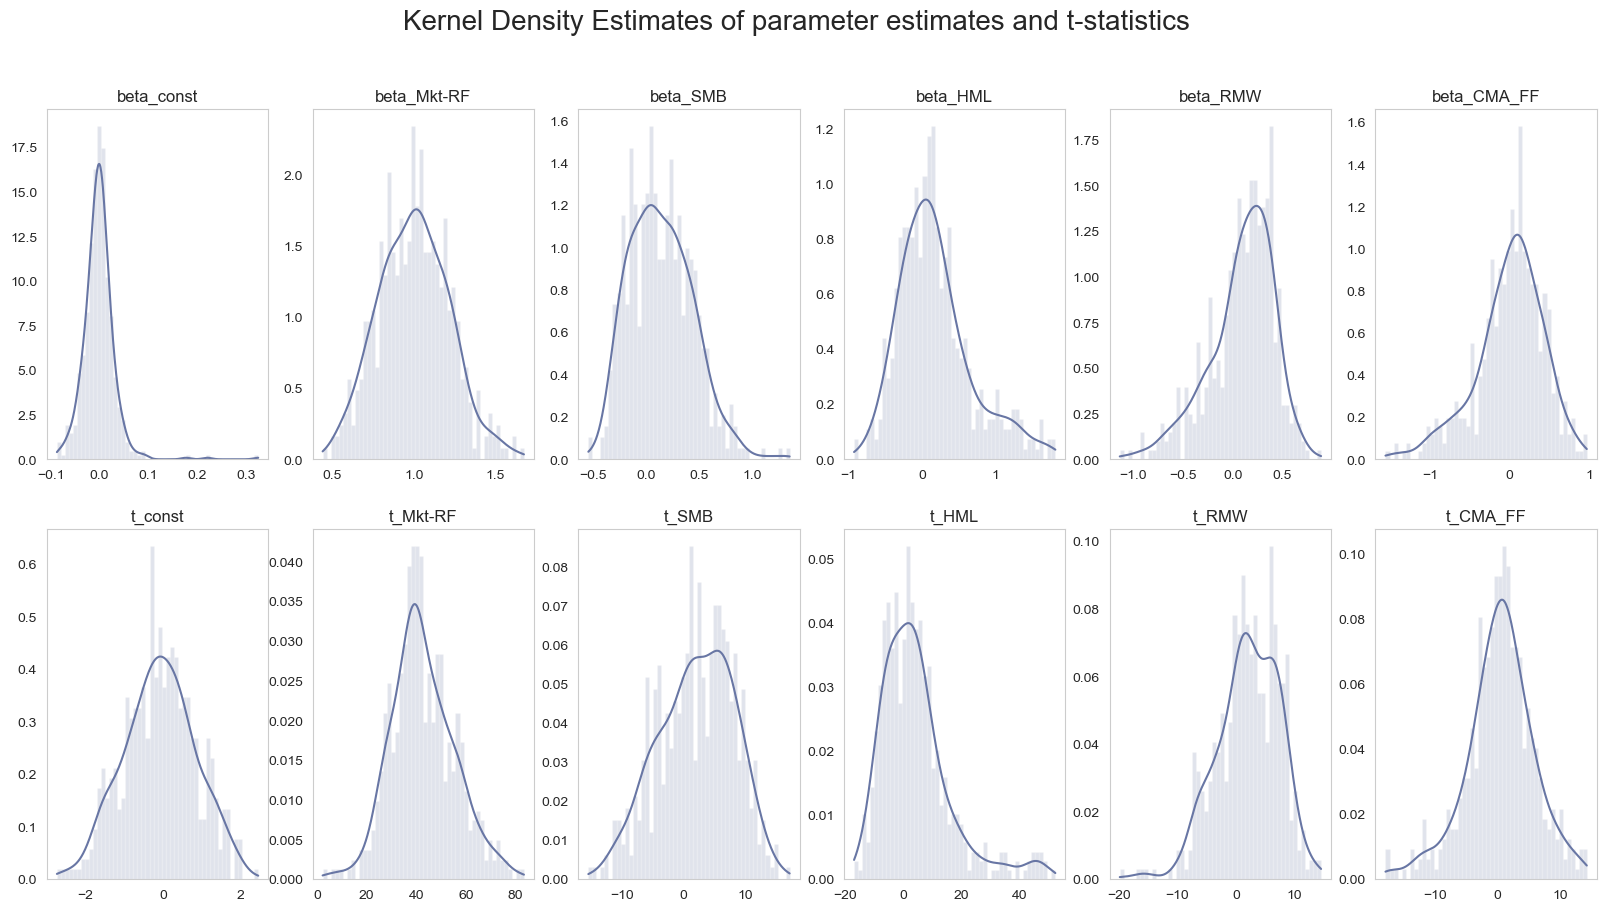

In [155]:
def kde_statistics(df_ols_results, df_ols_results2 = None, label1 = "daily", label2 = "monthly"):
    # Create histograms of estimate and every t-statistic
    fig, axs = plt.subplots(2, 6, figsize = (20, 10))
    axs = axs.reshape(-1)
    colnames = df_ols_results.columns[1:]

    for i, ax in enumerate(axs):
        if i >= len(colnames):
            break
        vals = df_ols_results.iloc[:,1+i]
        d = stats.gaussian_kde(vals)
        ind = np.linspace(min(vals),max(vals),500)
        kdepdf = d.evaluate(ind)
        ax.plot(ind, kdepdf, label=label1, color = DARK_COL)
        ax.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
        ax.grid(False)
        ax.set_title(colnames[i])
        if not df_ols_results2 is None:
            vals = df_ols_results2.iloc[:,1+i]
            d = stats.gaussian_kde(vals)
            ind = np.linspace(min(vals),max(vals),500)
            kdepdf = d.evaluate(ind)
            ax.plot(ind, kdepdf, label=label2, color = LIGHT_COL, ls = "--")
            ax.legend()
            ax.hist(vals, density = True, bins = 50, color = LIGHT_COL, alpha = 0.2)
    plt.suptitle("Kernel Density Estimates of parameter estimates and t-statistics", size = 20)
    plt.show()

kde_statistics(df_ols_results)

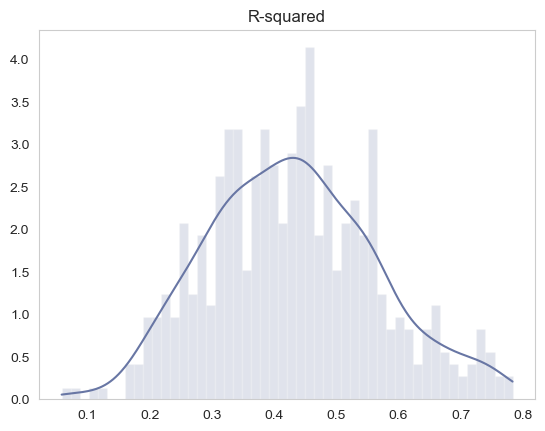

In [157]:
def plot_r_squared(df_ols_results, df_ols_results_monthly = None, label1 = "daily", label2 = "monthly"):
    # Plot R-squared
    vals = df_ols_results["R2"]
    d = stats.gaussian_kde(vals)
    ind = np.linspace(min(vals),max(vals),500)
    kdepdf = d.evaluate(ind)
    plt.plot(ind, kdepdf, label=label1, color = DARK_COL)
    plt.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
    if not df_ols_results_monthly is None:
        vals = df_ols_results_monthly["R2"]
        d = stats.gaussian_kde(vals)
        ind = np.linspace(min(vals),max(vals),500)
        kdepdf = d.evaluate(ind)
        plt.plot(ind, kdepdf, label=label2, color = LIGHT_COL, ls = "--")
        plt.hist(vals, density = True, bins = 50, color = LIGHT_COL, alpha = 0.2)
        plt.legend()
    plt.grid(False)
    plt.title("R-squared")
    plt.show()

plot_r_squared(df_ols_results)

**Comment:** From these plots we can make the following observations.

First of all, a lot of the coefficient estimates of the FF-factors seem to statistically significant. The factor that is clearly the most important is $R_m - R_f$, with the t-statistic distribution having a mean of around 40. This means that in almost all cases the market factor has a positive impact on the stock returns. Furthermore we observe that the t-statistics are generally greater (in absolute value) than 1.96, which means that we reject the hypothesis that the factors have no impact on the excess returns. Indeed, the t-statistics for SMB, HML, RMW and CMA have a large range (on average -15 to 15) with a distribution that is fairly normal.

In fact we observe that most parameter estimates seem to be relatively normally distributed, with the exception of HML and RMW, which have a parameter distribution that is skewed to the right and left respectively. Since the corresponding t-statistics are merely a scaled version of the parameter estimates, it is not surprising that most t-statistics are normally distributed as well.

The R-squared distribution estimate looks fairly normal, with a mean of around 0.4. That indicates that the FF-factors can explain (on average) 40% of the total variance of excess returns.

# 4. How differ the estimated factor coefficients according to the 11 sectors of the Global Industry Classification Standard?

In [13]:
def add_sector(df):
    df = df.copy()
    stocks = df["stock"]
    df["sector"] = ""
    for i, stock in enumerate(tqdm.tqdm(stocks)):
        ticker = yf.Ticker(stock)
        try:
            sector = ticker.get_info()["sector"]
        except KeyError:
            print(f"No sector found for {stock}")
        df.iloc[i, -1] = sector
    return df

In [14]:
df_results_sector = add_sector(df_ols_results)

 16%|█▌        | 80/500 [00:13<01:12,  5.78it/s]

No sector found for CAT


100%|██████████| 500/500 [01:19<00:00,  6.31it/s]


In [203]:
def plot_violin_sector(df, df2 = None):
    monthly_daily = False
    if not df2 is None:
        monthly_daily = True
    sns.set_style("whitegrid")
    # Create histograms of estimates for every industry
    fig, axs = plt.subplots(2, 3, figsize = (20, 15), sharey=True, squeeze=True)
    #plt.close('all')
    axs = axs.reshape(-1)
    coef_names = df_ols_results.columns[1:(len(axs)+1)]
    

    for i, ax in enumerate(axs):
        D = pd.pivot(df[[coef_names[i], "sector"]],columns='sector', values=coef_names[i])
        ax = sns.violinplot(D, widths=2, showmeans=True, showmedians=False, showextrema=False, inner = None if monthly_daily else "box", orient = "h", ax=ax, color = "grey" if monthly_daily else None)
        
        if not df2 is None:
            D = pd.pivot(df2[[coef_names[i], "sector"]],columns='sector', values=coef_names[i])
            ax = sns.violinplot(D, widths=2, showmeans=True, showmedians=False, showextrema=False, inner = None, linewidth=5, orient = "h", ax=ax)
            
            for violin in ax.collections:
                violin.set_alpha(0.2)
            fig.suptitle("Difference daily (thin lines) vs. monthly (thick lines)", fontsize=20)
        ax.set_ylabel("")
        ax.grid(False)
        ax.set_title(coef_names[i])
    plt.tight_layout()
    


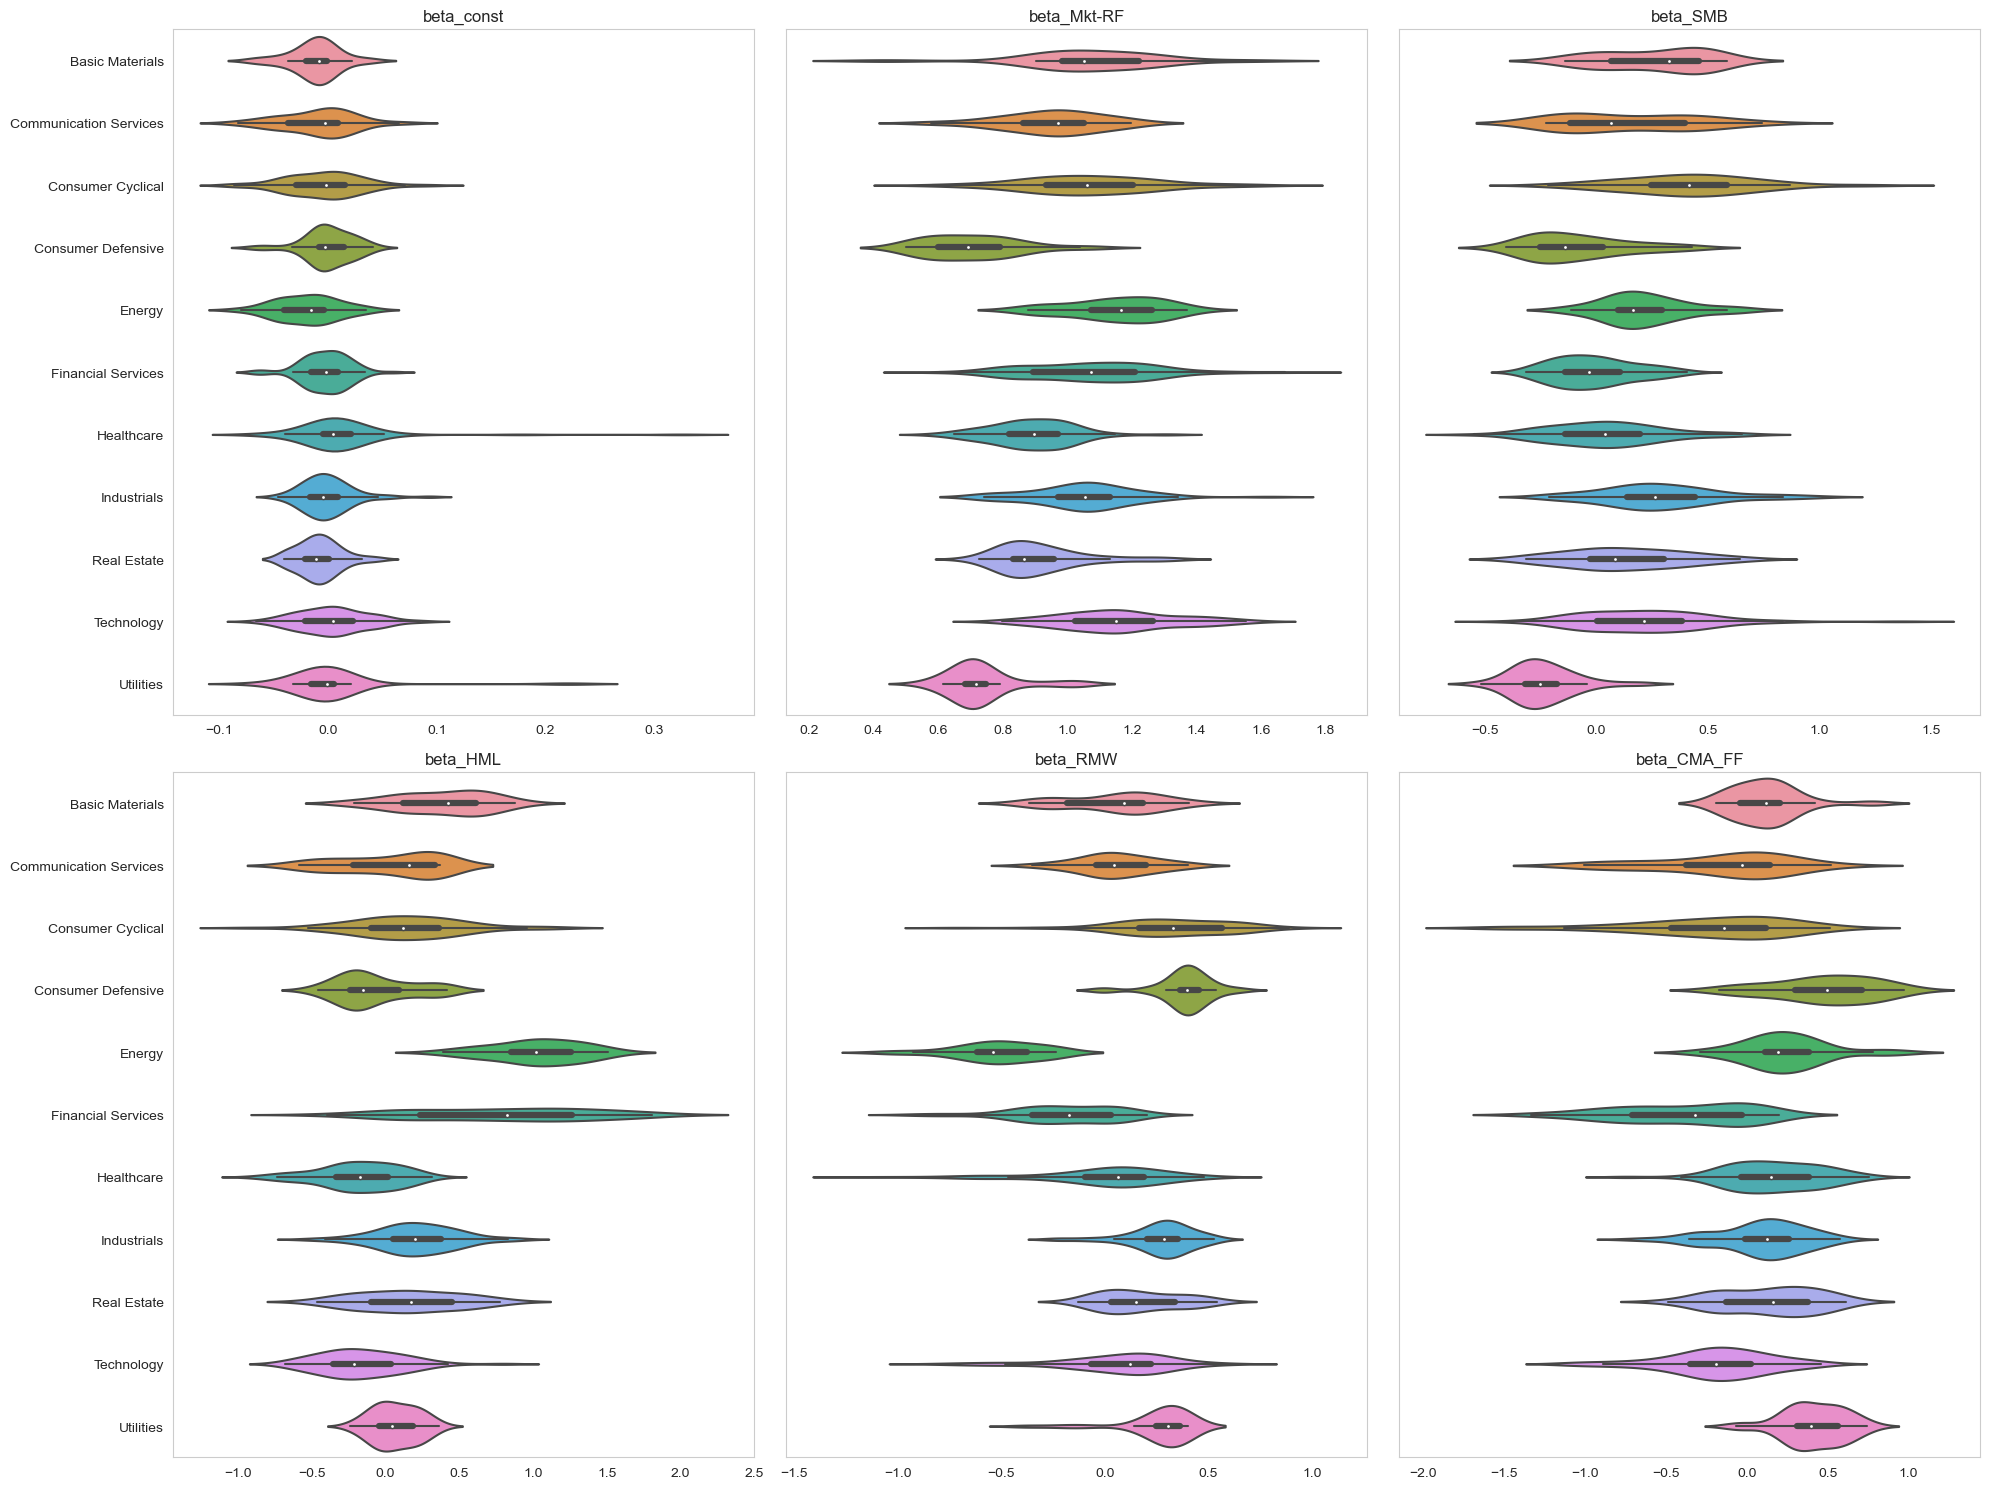

In [202]:
plot_violin_sector(df_results_sector)

**Comment** 

In these plots we can observe the distribution of the distribution of each coefficient for every sector. For the constant we do not observe a considerable difference. That being said, for the other coefficients, we observe differences among all sectors. For instance, for the market factor, we see that consumer cyclical and utilies are less influenced by the market, whereas sectors like Energy and Technology are heavily market-influenced with an average coefficient above 1. That being said, we observe that all sectors are positively influenced by the market.

 **ADD COMMENT**

In [16]:
def plot_kde_sector(df):
    # Create histograms of estimates for every industry
    fig, axs = plt.subplots(2, 3, figsize = (20, 15))
    axs = axs.reshape(-1)
    coef_names = df_ols_results.columns[1:(len(axs)+1)]
    sns.set_style("whitegrid")


    for sector in df["sector"].unique():
        df_sector = df_ols_results[df["sector"] == sector]
        for i, ax in enumerate(axs):
            vals = df_sector.iloc[:,i+1]
            d = stats.gaussian_kde(vals)
            ind = np.linspace(min(vals)-0.2,max(vals) + 0.3,500)
            kdepdf = d.evaluate(ind)
            ax.plot(ind, kdepdf, label=sector)
            #ax.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
            ax.legend()
            ax.grid(False)
            ax.set_title(coef_names[i])
            #plt.show()

# 5. Is it possible to cluster the stocks in groups in an unsupervised way? How many clusters do you recommend and what are typical characteristics of each cluster.

## 1st approach: Clustering based on FF-coefficients
- Best approach: Interpretability & clear clusters

In [89]:
def prep_cluster_ff_coefs(df_ols_results):
    df_ff_clustering = df_ols_results.copy()
    cols_of_interest = df_ols_results.columns[:13]
    df_ff_clustering = df_ff_clustering[cols_of_interest]
    df_ff_clustering.index = df_ff_clustering["stock"].values
    df_ff_clustering = df_ff_clustering.drop("stock", axis = 1)
    return df_ff_clustering

df_ff_clustering = prep_cluster_ff_coefs(df_ols_results)
df_ff_clustering

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF
A,-0.002305,1.147959,0.042657,-0.177300,-0.233549,0.126154,-0.109378,57.002653,1.119691,-4.897151,-4.606567,1.814028
AAL,-0.026688,1.273091,0.834769,0.770071,0.242065,-0.354723,-0.558791,27.894745,9.668788,9.385569,2.106813,-2.250754
AAP,-0.015915,0.842018,0.328666,0.037590,0.583783,0.039670,-0.533398,29.532887,6.093703,0.733374,8.133292,0.402918
AAPL,0.025276,1.178569,-0.175437,-0.497186,0.595589,-0.023429,1.187734,57.955289,-4.560390,-13.599535,11.633620,-0.333626
ABBV,0.028364,0.791503,-0.140691,-0.128710,0.082057,0.368701,0.967088,28.303818,-2.715757,-2.667284,1.187549,3.975081
...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.007844,0.855561,-0.030755,0.042028,0.327987,0.066486,0.371545,42.407796,-0.805852,1.158775,6.457755,0.954337
ZBH,-0.018393,0.860477,0.193156,0.166984,0.117461,-0.168361,-0.829151,40.593153,4.816855,4.381841,2.201089,-2.300014
ZBRA,0.005819,1.202005,0.416916,-0.265489,0.188217,-0.103430,0.193632,41.857025,7.674556,-5.142510,2.603470,-1.043000
ZION,-0.003125,1.049921,0.337522,1.631795,-0.552389,-0.945908,-0.130749,45.974141,7.812696,39.745633,-9.607990,-11.994491


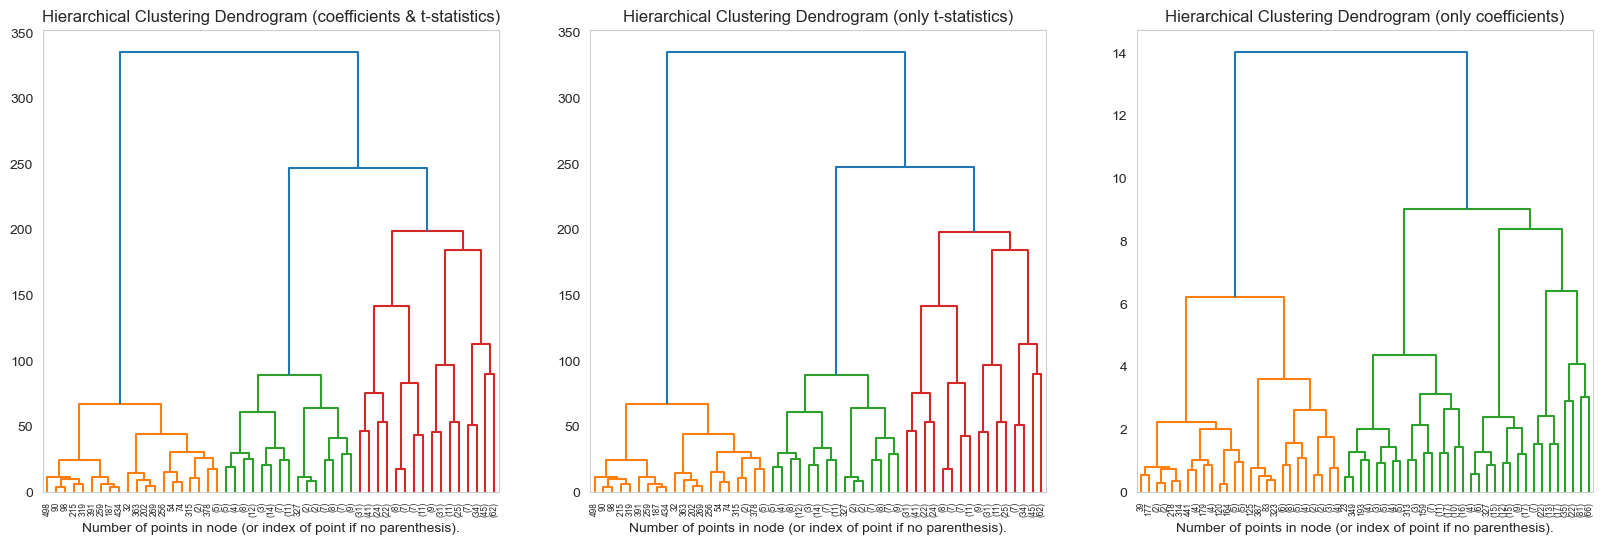

In [173]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def plot_dendrogram_ff(df_ols_results, p = 5):
    colranges = [(1, 13), (6,12), (1,6)]
    titles = ["(coefficients & t-statistics)", "(only t-statistics)", "(only coefficients)"]
    fig, axs = plt.subplots(1, 3, figsize = (20, 6))
    sns.set_style("whitegrid")
    for i, (ax, (col_min, col_max)) in enumerate(zip(axs,colranges)):
        df_ff_clustering = df_ols_results.copy()
        cols_of_interest = df_ols_results.columns[col_min:col_max]
        df_ff_clustering = df_ff_clustering[cols_of_interest]

        # setting distance_threshold=0 ensures we compute the full tree.
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

        model = model.fit(df_ff_clustering)
        ax.set_title(f"Hierarchical Clustering Dendrogram {titles[i]}")
        # plot the top three levels of the dendrogram
        plot_dendrogram(model, truncate_mode="level", p=p, ax= ax)
        ax.grid(False)
        ax.set_xlabel("Number of points in node (or index of point if no parenthesis).")

plot_dendrogram_ff(df_ols_results)

The methodology to choose the amount of clusters is th following: we imagine a horizontal line that slices the tree in two where the vertical lines are the longest. The number of lines being cut determines the number of clusters. From these dendrograms we can see that we by using **only t-statistics** we are able to separate stocks into **6 distinct clusters**. We will now see how these clusters differ and what characteristics each cluster has.

In [191]:
df_ff_clustering = df_ols_results.iloc[:,1:].copy()

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=6)

model = model.fit(df_ff_clustering)


In [194]:
df_clustering_result = df_ols_results.copy()
df_clustering_result["cluster"] = model.labels_
df_clustering_result = df_clustering_result.set_index("stock")

In [193]:
df_clustering_result

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2,cluster
stock,,,,,,,,,,,,,,
A,-0.002305,1.147959,0.042657,-0.177300,-0.233549,0.126154,-0.109378,57.002653,1.119691,-4.897151,-4.606567,1.814028,0.555602,1
AAL,-0.026688,1.273091,0.834769,0.770071,0.242065,-0.354723,-0.558791,27.894745,9.668788,9.385569,2.106813,-2.250754,0.302043,2
AAP,-0.015915,0.842018,0.328666,0.037590,0.583783,0.039670,-0.533398,29.532887,6.093703,0.733374,8.133292,0.402918,0.250085,5
AAPL,0.025276,1.178569,-0.175437,-0.497186,0.595589,-0.023429,1.187734,57.955289,-4.560390,-13.599535,11.633620,-0.333626,0.539743,1
ABBV,0.028364,0.791503,-0.140691,-0.128710,0.082057,0.368701,0.967088,28.303818,-2.715757,-2.667284,1.187549,3.975081,0.245479,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.007844,0.855561,-0.030755,0.042028,0.327987,0.066486,0.371545,42.407796,-0.805852,1.158775,6.457755,0.954337,0.377465,0
ZBH,-0.018393,0.860477,0.193156,0.166984,0.117461,-0.168361,-0.829151,40.593153,4.816855,4.381841,2.201089,-2.300014,0.398804,5
ZBRA,0.005819,1.202005,0.416916,-0.265489,0.188217,-0.103430,0.193632,41.857025,7.674556,-5.142510,2.603470,-1.043000,0.416724,0


### Interpret clusters

In [197]:
df_clustering_result.groupby("cluster").mean()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
cluster,,,,,,,,,,,,,
0,0.003353,0.899772,-0.018235,-0.111706,0.176103,0.196593,0.149640,42.211979,-1.647858,-2.706038,3.857573,3.480024,0.390948
1,-0.001355,1.105417,0.075972,0.066575,0.188573,0.009724,-0.039847,59.305490,1.856212,2.006162,4.189373,0.312574,0.569652
2,0.016348,0.937118,0.190564,-0.038504,-0.098533,-0.000015,0.285375,26.766988,2.295647,-0.817736,-0.363491,0.559760,0.286506
3,-0.012039,1.165443,0.033732,1.363090,-0.376667,-0.729889,-0.633179,65.166356,0.479182,41.745335,-8.078522,-11.354498,0.722197
4,-0.015269,1.133850,0.114556,0.989881,-0.295595,-0.057181,-0.483714,47.211482,1.769502,22.302379,-3.971046,-1.118262,0.533791
5,-0.014911,1.036012,0.367717,0.317191,0.284906,-0.065883,-0.495447,40.409360,7.169983,6.785656,4.490643,-0.456332,0.418566


**Comment:**

## 2nd approach: Clustering based on spectral features extracted from returns time series

- No clear differences among the different time series -> difficult to cluster
- Features difficult to interpret!

In [19]:
returns.fillna(0)

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,-1.092166,10.724563,-0.596149,0.172770,0.000000,-0.716046,-0.811195,-0.334110,0.616135,...,5.904167,-1.193060,0.389701,-1.195930,0.000000,-0.342586,3.116528,-0.174548,3.465158,0.000000
2,2010-01-06,-0.355955,-4.231411,0.868152,-1.603434,0.000000,-0.950013,0.553758,-0.433244,1.057452,...,-1.320423,0.191861,0.860535,0.656664,0.000000,-0.717446,-0.032290,-0.771667,8.338131,0.000000
3,2010-01-07,-0.129771,2.904340,-0.024734,-0.185038,0.000000,-1.616682,0.825047,-0.589966,-0.093530,...,2.113132,-0.432173,-0.314650,1.300615,0.000000,-0.028801,2.268099,-2.531778,10.616022,0.000000
4,2010-01-08,-0.032452,-1.926821,0.394523,0.662638,0.000000,1.080681,0.509911,-0.197437,-0.398564,...,-0.719045,0.048133,-0.401974,0.000000,0.000000,0.028801,-2.122795,-0.325557,-1.631939,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,...,-0.225444,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,...,0.814801,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,...,1.701705,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,...,-0.045863,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


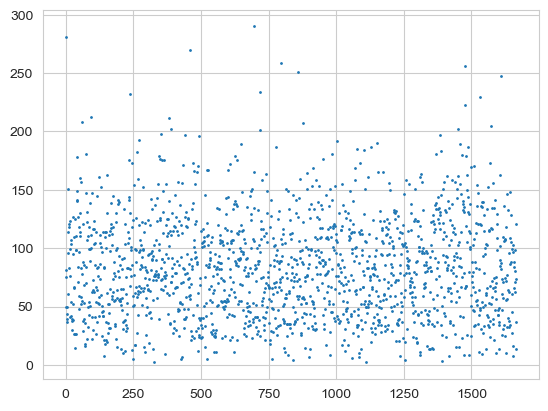

In [20]:
from scipy.fft import fft

stocks = returns.columns[1:] # Excludes Date
X = returns[stocks].fillna(0)
ys = []
for i, stock in enumerate(stocks):
    vals = X[stock].to_numpy()
    y = fft(vals)
    ys.append(y)
ys = np.array(ys)
intensity_freqs = abs(ys)[:, :ys.shape[1]//2]
y = intensity_freqs[111]
plt.scatter(range(len(y)), y, s = 1)
plt.show()

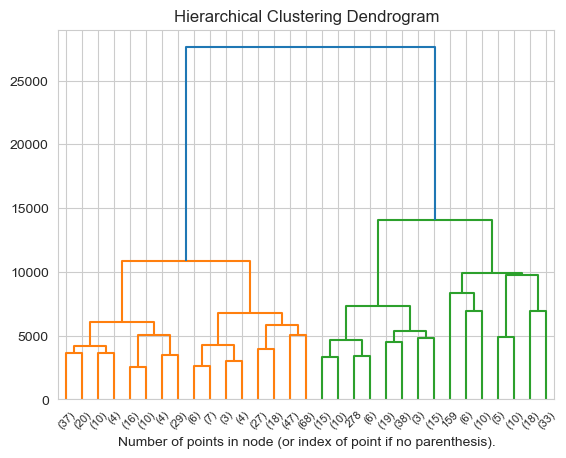

In [21]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(intensity_freqs)
plt.title(f"Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## 3rd approach: Clustering based on raw returns time series

Difficult to extract common characteristics out of the raw time series.

In [22]:
stocks = returns.columns[1:] # Excludes Date
X = df[stocks]

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10
1,-1.092166,10.724563,-0.596149,0.172770,0.172770,-0.716046,-0.811195,-0.334110,0.616135,1.631272,...,-1.193060,0.389701,-1.195930,-1.195930,-0.342586,3.116528,-0.174548,3.465158,3.465158,8
2,-0.355955,-4.231411,0.868152,-1.603434,-1.603434,-0.950013,0.553758,-0.433244,1.057452,-0.212432,...,0.191861,0.860535,0.656664,0.656664,-0.717446,-0.032290,-0.771667,8.338131,8.338131,8
3,-0.129771,2.904340,-0.024734,-0.185038,-0.185038,-1.616682,0.825047,-0.589966,-0.093530,-1.959530,...,-0.432173,-0.314650,1.300615,1.300615,-0.028801,2.268099,-2.531778,10.616022,10.616022,8
4,-0.032452,-1.926821,0.394523,0.662638,0.662638,1.080681,0.509911,-0.197437,-0.398564,-0.543629,...,0.048133,-0.401974,0.000000,0.000000,0.028801,-2.122795,-0.325557,-1.631939,-1.631939,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,-0.483886,...,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596,8
3330,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,0.066975,...,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149,8
3331,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,1.530807,...,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560,5
3332,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,0.720049,...,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838,10


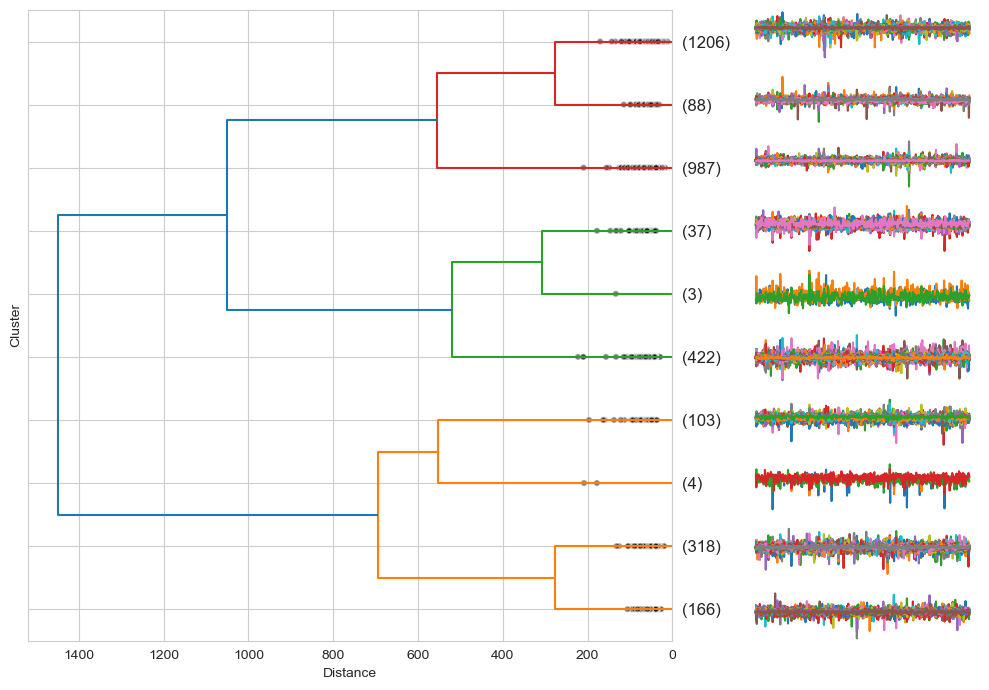

In [23]:
from dendrogram_ts import maxclust_draw

sns.set_style('whitegrid')
plt.figure(figsize=(10,7));

maxclust_draw(X.fillna(method="ffill", axis = 1), 'ward', metric= "euclidean", max_cluster=10, ts_hspace=3)

# 6. Sort the estimated constants and provide the names of the five companies with the highest constant and the five with lowest constant. Comment.

In [108]:

def print_top_bottom_5(df_ols_results):
    df_constants = df_ols_results[["stock", "beta_const"]]
    df_constants = df_constants.sort_values(by ="beta_const", ascending=False)
    top_5 = df_constants.iloc[:5]
    bottom_5 = df_constants.iloc[-5:]

    print("############## Top 5 Companies ###############")
    i = 1
    for _, row in top_5.iterrows():
        stock, const = row
        ticker = yf.Ticker(stock)
        name = ticker.get_info()["longName"]
        print(f"{i}. {name} (alpha: {const: .3f})")
        i += 1
    
    print("############ Bottom 5 Companies ##############")
    i = 0
    for _, row in bottom_5.iterrows():
        stock, const = row
        ticker = yf.Ticker(stock)
        name = ticker.get_info()["longName"]
        print(f"{496+i}. {name} (alpha: {const: .3f})")
        i += 1

In [109]:
print_top_bottom_5(df_ols_results)

############## Top 5 Companies ###############
1. GE HealthCare Technologies Inc. (alpha:  0.325)
2. Constellation Energy Corporation (alpha:  0.221)
3. Moderna, Inc. (alpha:  0.177)
4. Tesla, Inc. (alpha:  0.093)
5. Carrier Global Corporation (alpha:  0.093)
############ Bottom 5 Companies ##############
496. WestRock Company (alpha: -0.078)
497. APA Corporation (alpha: -0.080)
498. Carnival Corporation & plc (alpha: -0.081)
499. DISH Network Corporation (alpha: -0.082)
500. Norwegian Cruise Line Holdings Ltd. (alpha: -0.087)


**Comment:**

# 7. Temporally aggregating your returns to monthly frequency and taking monthly Fama-French data, redo the analysis and compare your findings with the daily frequency results.

## 7.1 Get monthly data

In [26]:
# Download monthly data from 2010 onwards up to last day of FF
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 4, 1) # Last day of FF
data_monthly = yf.download(tickers, start = start, end = end, interval="1mo")
prices_monthly = data_monthly["Adj Close"].reset_index()
# Drop columns without any data
prices_monthly = prices_monthly.drop(["BF.B", "BRK.B", "HON"], axis=1)

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [38]:
prices_monthly

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,^GSPC
0,2010-01-01,18.300039,5.005957,37.547535,5.898321,NaN,22.624672,19.226805,7.948889,32.124466,...,13.734278,40.237892,31.112370,NaN,19.401821,49.998180,26.100000,16.480963,NaN,1073.869995
1,2010-02-01,20.539387,6.910295,38.832451,6.284050,NaN,23.272045,19.857437,8.220000,31.325090,...,13.754104,40.593868,30.704088,NaN,19.236164,50.894810,28.570000,16.107380,NaN,1104.489990
2,2010-03-01,22.452307,6.929150,39.898415,7.217045,NaN,24.073309,19.272106,8.472222,32.876835,...,14.011874,42.103313,32.365032,NaN,21.866020,52.554913,29.600000,18.984936,NaN,1169.430054
3,2010-04-01,23.673182,6.665183,42.983742,8.018289,NaN,25.679865,18.716043,8.397778,34.201305,...,14.541085,42.599895,34.056648,NaN,24.199232,54.072968,29.049999,24.974226,NaN,1186.689941
4,2010-05-01,21.126976,8.324407,49.331234,7.888996,NaN,26.037804,17.545616,8.168889,29.663067,...,13.698705,38.004868,30.135260,NaN,23.480440,49.651962,27.500000,20.819105,NaN,1089.410034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2022-11-01,154.979996,14.430000,150.990005,148.029999,161.179993,170.690002,107.580002,59.910000,300.929993,...,70.220001,111.339996,30.260000,112.349998,128.660004,120.099998,270.279999,51.820000,154.139999,4080.110107
155,2022-12-01,149.649994,12.720000,147.029999,129.929993,161.610001,165.710007,109.790001,62.779999,266.839996,...,70.110001,110.300003,31.840000,110.570000,128.080002,127.500000,256.410004,49.160000,146.550003,3839.500000
156,2023-01-01,152.080002,16.139999,152.279999,144.289993,147.750000,168.960007,110.550003,64.349998,279.049988,...,68.769997,116.010002,36.830002,104.010002,130.509995,127.339996,316.179993,53.160000,165.490005,4076.600098
157,2023-02-01,141.970001,15.980000,144.960007,147.410004,153.899994,155.559998,101.720001,70.000000,265.549988,...,64.570000,109.910004,38.070000,102.650002,127.160004,123.870003,300.250000,50.619999,167.000000,3970.149902


In [94]:
# Compute returns
returns_monthly = prices_monthly.copy()
Diffs_monthly = np.diff(returns_monthly.iloc[:,1:],axis=0)
Returns_monthly = Diffs_monthly*100/prices_monthly.iloc[:-1,1:]
# We assume the first return to be 0
Returns_monthly = np.vstack((np.zeros(Returns_monthly.shape[1]),Returns_monthly))
returns_monthly.iloc[:,1:] = Returns_monthly
# Isolate S&P 500
sp500_monthly = returns_monthly[["Date","^GSPC"]]
returns_monthly = returns_monthly.drop("^GSPC", axis = 1)
returns_monthly

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-02-01,12.236845,38.041425,3.422105,6.539646,NaN,2.861359,3.279965,3.410684,-2.488370,...,2.731087,0.144354,0.884679,-1.312280,NaN,-0.853822,1.793324,9.463599,-2.266754,NaN
2,2010-03-01,9.313423,0.272862,2.745033,14.847031,NaN,3.443031,-2.947666,3.068395,4.953679,...,19.285833,1.874135,3.718407,5.409521,NaN,13.671416,3.261831,3.605183,17.864829,NaN
3,2010-04-01,5.437636,-3.809515,7.732957,11.102103,NaN,6.673598,-2.885324,-0.878692,4.028583,...,16.365562,3.776876,1.179437,5.226678,NaN,10.670492,2.888512,-1.858112,31.547593,NaN
4,2010-05-01,-10.755654,24.893893,14.767193,-1.612470,NaN,1.393850,-6.253604,-2.725584,-13.269197,...,-4.941048,-5.793106,-10.786477,-11.514312,NaN,-2.970309,-8.175999,-5.335626,-16.637636,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2022-11-01,12.020230,1.763047,-20.498101,-3.462891,10.095628,8.567613,8.732564,4.191304,5.998591,...,30.923320,7.848258,0.478295,-1.817000,9.684661,8.803386,5.955007,-4.568887,-0.231034,2.228413
155,2022-12-01,-3.439155,-11.850312,-2.622695,-12.227255,0.266787,-2.917567,2.054284,4.790517,-11.328215,...,-1.422427,-0.156651,-0.934070,5.221414,-1.584334,-0.450802,6.161533,-5.131713,-5.133153,-4.924093
156,2023-01-01,1.623794,26.886785,3.570700,11.052106,-8.576202,1.961258,0.692233,2.500796,4.575773,...,25.669938,-1.911288,5.176790,15.672116,-5.932891,1.897246,-0.125493,23.310319,8.136697,12.923918
157,2023-02-01,-6.647817,-0.991325,-4.806929,2.162319,4.162432,-7.930876,-7.987337,8.780111,-4.837843,...,4.563878,-6.107310,-5.258166,3.366815,-1.307567,-2.566846,-2.724983,-5.038267,-4.778030,0.912438


In [95]:
# Read monthly FF data
ff_monthly = pd.read_csv("./data/F-F_Research_Data_5_Factors_2x3.csv")
ff_monthly = ff_monthly.rename({"Unnamed: 0": "Date"}, axis = 1)
ff_monthly["Date"] = pd.to_datetime(ff_monthly["Date"], format="%Y%m")
# Merge dataframes based on date
df_monthly = pd.merge(ff_monthly, returns_monthly, on = "Date", how = "inner", suffixes=["_FF", ""])
df_monthly

,Date,Mkt-RF,SMB,HML,RMW,CMA_FF,RF_FF,A,AAL,AAP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-01,-3.36,0.34,0.43,-1.27,0.46,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-02-01,3.40,1.51,3.23,-0.27,1.43,0.00,12.236845,38.041425,3.422105,...,2.731087,0.144354,0.884679,-1.312280,NaN,-0.853822,1.793324,9.463599,-2.266754,NaN
2,2010-03-01,6.31,1.85,2.21,-0.65,1.69,0.01,9.313423,0.272862,2.745033,...,19.285833,1.874135,3.718407,5.409521,NaN,13.671416,3.261831,3.605183,17.864829,NaN
3,2010-04-01,2.00,4.98,2.89,0.69,1.72,0.01,5.437636,-3.809515,7.732957,...,16.365562,3.776876,1.179437,5.226678,NaN,10.670492,2.888512,-1.858112,31.547593,NaN
4,2010-05-01,-7.89,0.04,-2.44,1.30,-0.22,0.01,-10.755654,24.893893,14.767193,...,-4.941048,-5.793106,-10.786477,-11.514312,NaN,-2.970309,-8.175999,-5.335626,-16.637636,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2022-11-01,4.60,-2.67,1.38,6.01,3.11,0.29,12.020230,1.763047,-20.498101,...,30.923320,7.848258,0.478295,-1.817000,9.684661,8.803386,5.955007,-4.568887,-0.231034,2.228413
155,2022-12-01,-6.41,-0.16,1.32,0.09,4.19,0.33,-3.439155,-11.850312,-2.622695,...,-1.422427,-0.156651,-0.934070,5.221414,-1.584334,-0.450802,6.161533,-5.131713,-5.133153,-4.924093
156,2023-01-01,6.65,4.43,-4.05,-2.62,-4.53,0.35,1.623794,26.886785,3.570700,...,25.669938,-1.911288,5.176790,15.672116,-5.932891,1.897246,-0.125493,23.310319,8.136697,12.923918
157,2023-02-01,-2.58,0.69,-0.78,0.90,-1.41,0.34,-6.647817,-0.991325,-4.806929,...,4.563878,-6.107310,-5.258166,3.366815,-1.307567,-2.566846,-2.724983,-5.038267,-4.778030,0.912438


## 7.1 Estimate regression coefficients

In [96]:
X_monthly = prepare_data_ols(df_monthly)
df_ols_results_monthly = ols_estimation(df_monthly, X_monthly, returns_monthly)
df_ols_results_monthly

,stock,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
0,A,0.294073,1.214892,-0.020409,-0.148430,-0.259647,0.045813,0.690306,12.152276,-0.105645,-0.853735,-1.110339,0.170848,0.537087
1,AAL,0.374067,1.022034,1.218077,0.337466,0.492118,0.333777,0.359557,4.186176,2.581864,0.794812,0.861735,0.509688,0.225940
2,AAP,0.007499,0.796971,0.751893,0.185199,1.075425,-0.069573,0.011994,5.431428,2.651759,0.725758,3.133317,-0.176771,0.298700
3,AAPL,0.958511,1.151640,-0.162278,-0.469033,0.768141,-0.257709,1.975232,10.112796,-0.737431,-2.368322,2.883687,-0.843686,0.478058
4,ABBV,0.891144,0.802788,0.146737,-0.134273,0.158768,0.611667,1.389375,5.095952,0.506352,-0.533184,0.437334,1.566199,0.222899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,0.279013,0.819716,0.210830,0.026693,1.000235,-0.115702,0.671013,8.400491,1.118097,0.157297,4.382238,-0.442057,0.420283
496,ZBH,-0.171948,1.000043,-0.089467,0.016064,-0.467143,0.409826,-0.394960,9.788310,-0.453169,0.090410,-1.954753,1.495496,0.428354
497,ZBRA,0.798684,1.283209,0.741254,0.104372,0.274844,-1.147650,1.342329,9.189985,2.747204,0.429817,0.841505,-3.064241,0.513863
498,ZION,0.289053,1.059372,0.832311,1.595469,-0.768070,-0.985006,0.658653,10.286355,4.182200,8.908071,-3.188351,-3.565726,0.722930


## 7.2 Summary statistics

In [97]:
df_ols_results_monthly.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.406935,0.989043,0.116395,0.141607,0.063408,-0.007092,0.702330,8.293353,0.301886,0.738417,0.353814,0.063945,0.410854
std,0.738685,0.339928,0.415568,0.552230,0.477826,0.581766,1.023436,2.978373,1.621729,2.721745,1.692956,1.776871,0.158243
min,-1.271146,-0.526508,-1.966548,-2.430069,-2.221019,-2.506532,-2.370744,-0.000000,-4.897983,-5.270915,-5.530207,-5.917077,0.018100
25%,-0.023888,0.770178,-0.172368,-0.202409,-0.232392,-0.360026,-0.051890,6.197175,-0.763672,-1.014844,-0.773681,-1.103340,0.290650
50%,0.332994,0.979607,0.106053,0.073839,0.110252,0.027550,0.705583,8.125546,0.423973,0.358280,0.384400,0.082131,0.408858
75%,0.711033,1.199850,0.357114,0.416962,0.387927,0.369504,1.408802,10.207519,1.450061,1.788907,1.532043,1.171097,0.525314
max,5.381027,2.413347,2.158435,1.921799,1.473615,2.448846,3.219668,17.359277,5.048507,11.083772,4.825886,5.187524,1.000000


## 7.3 Plot KDEs of statistics

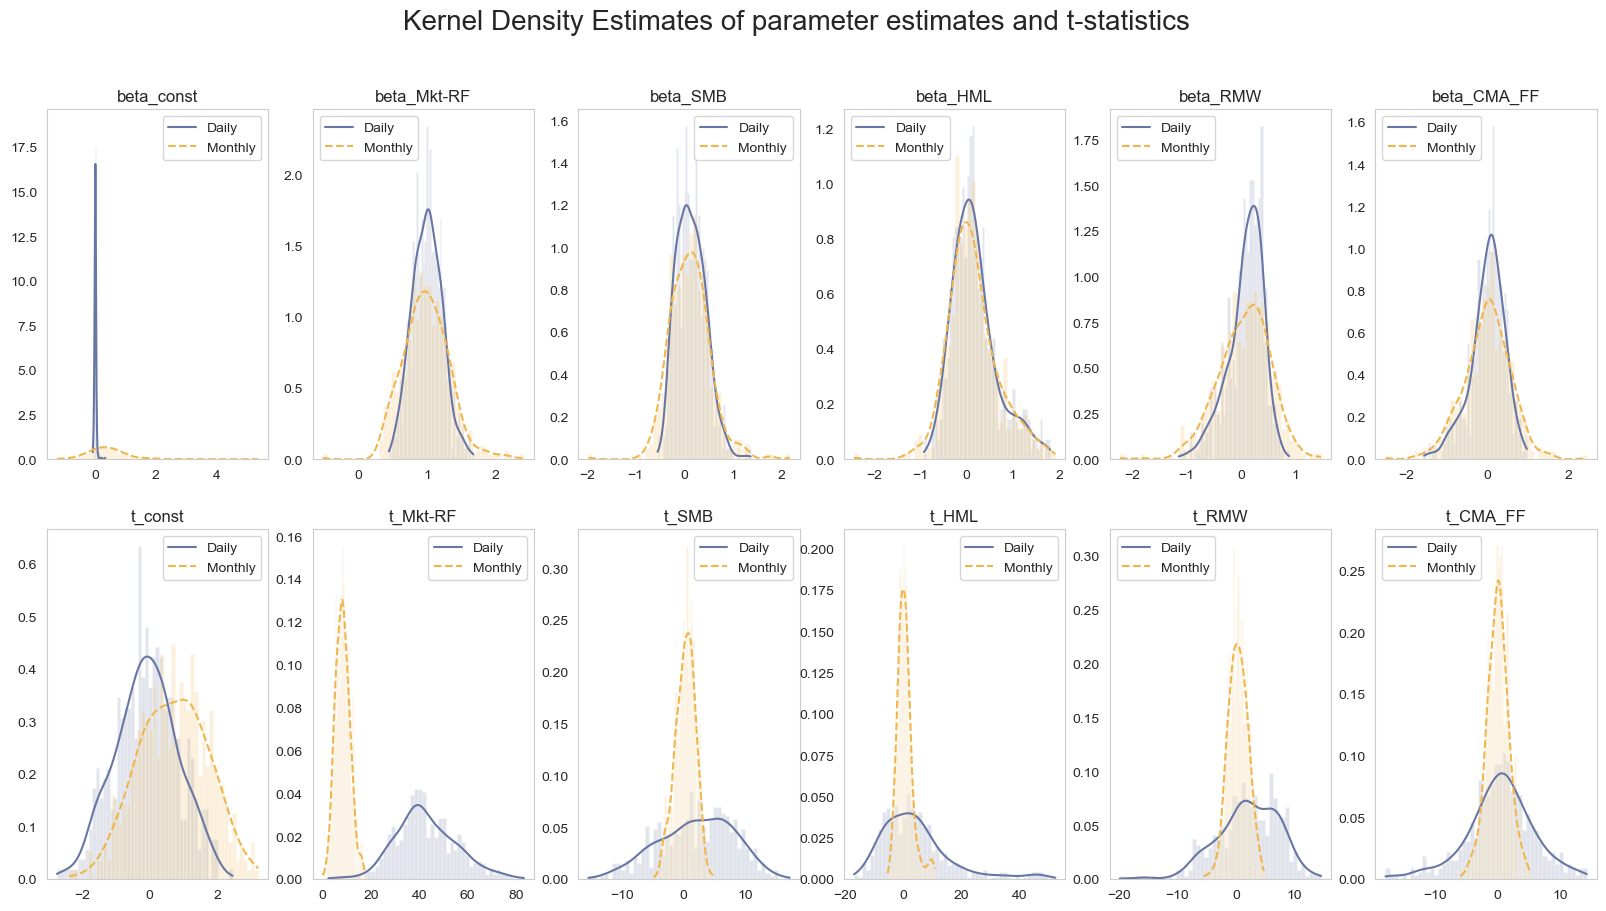

In [98]:
kde_statistics(df_ols_results, df_ols_results_monthly)

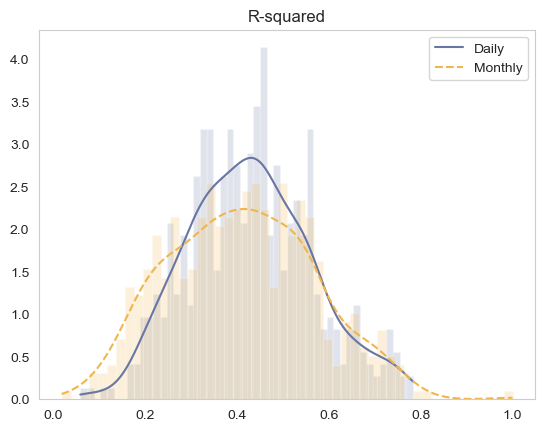

In [99]:
plot_r_squared(df_ols_results, df_ols_results_monthly)

**Outlier due to GEHC 3 data points with 5 regressors.**

## 7.4 Differences between sectors

In [100]:
df_results_sectors_monthly = add_sector(df_ols_results_monthly)

 16%|█▌        | 80/500 [00:17<01:17,  5.40it/s]

No sector found for CAT


100%|██████████| 500/500 [01:30<00:00,  5.50it/s]


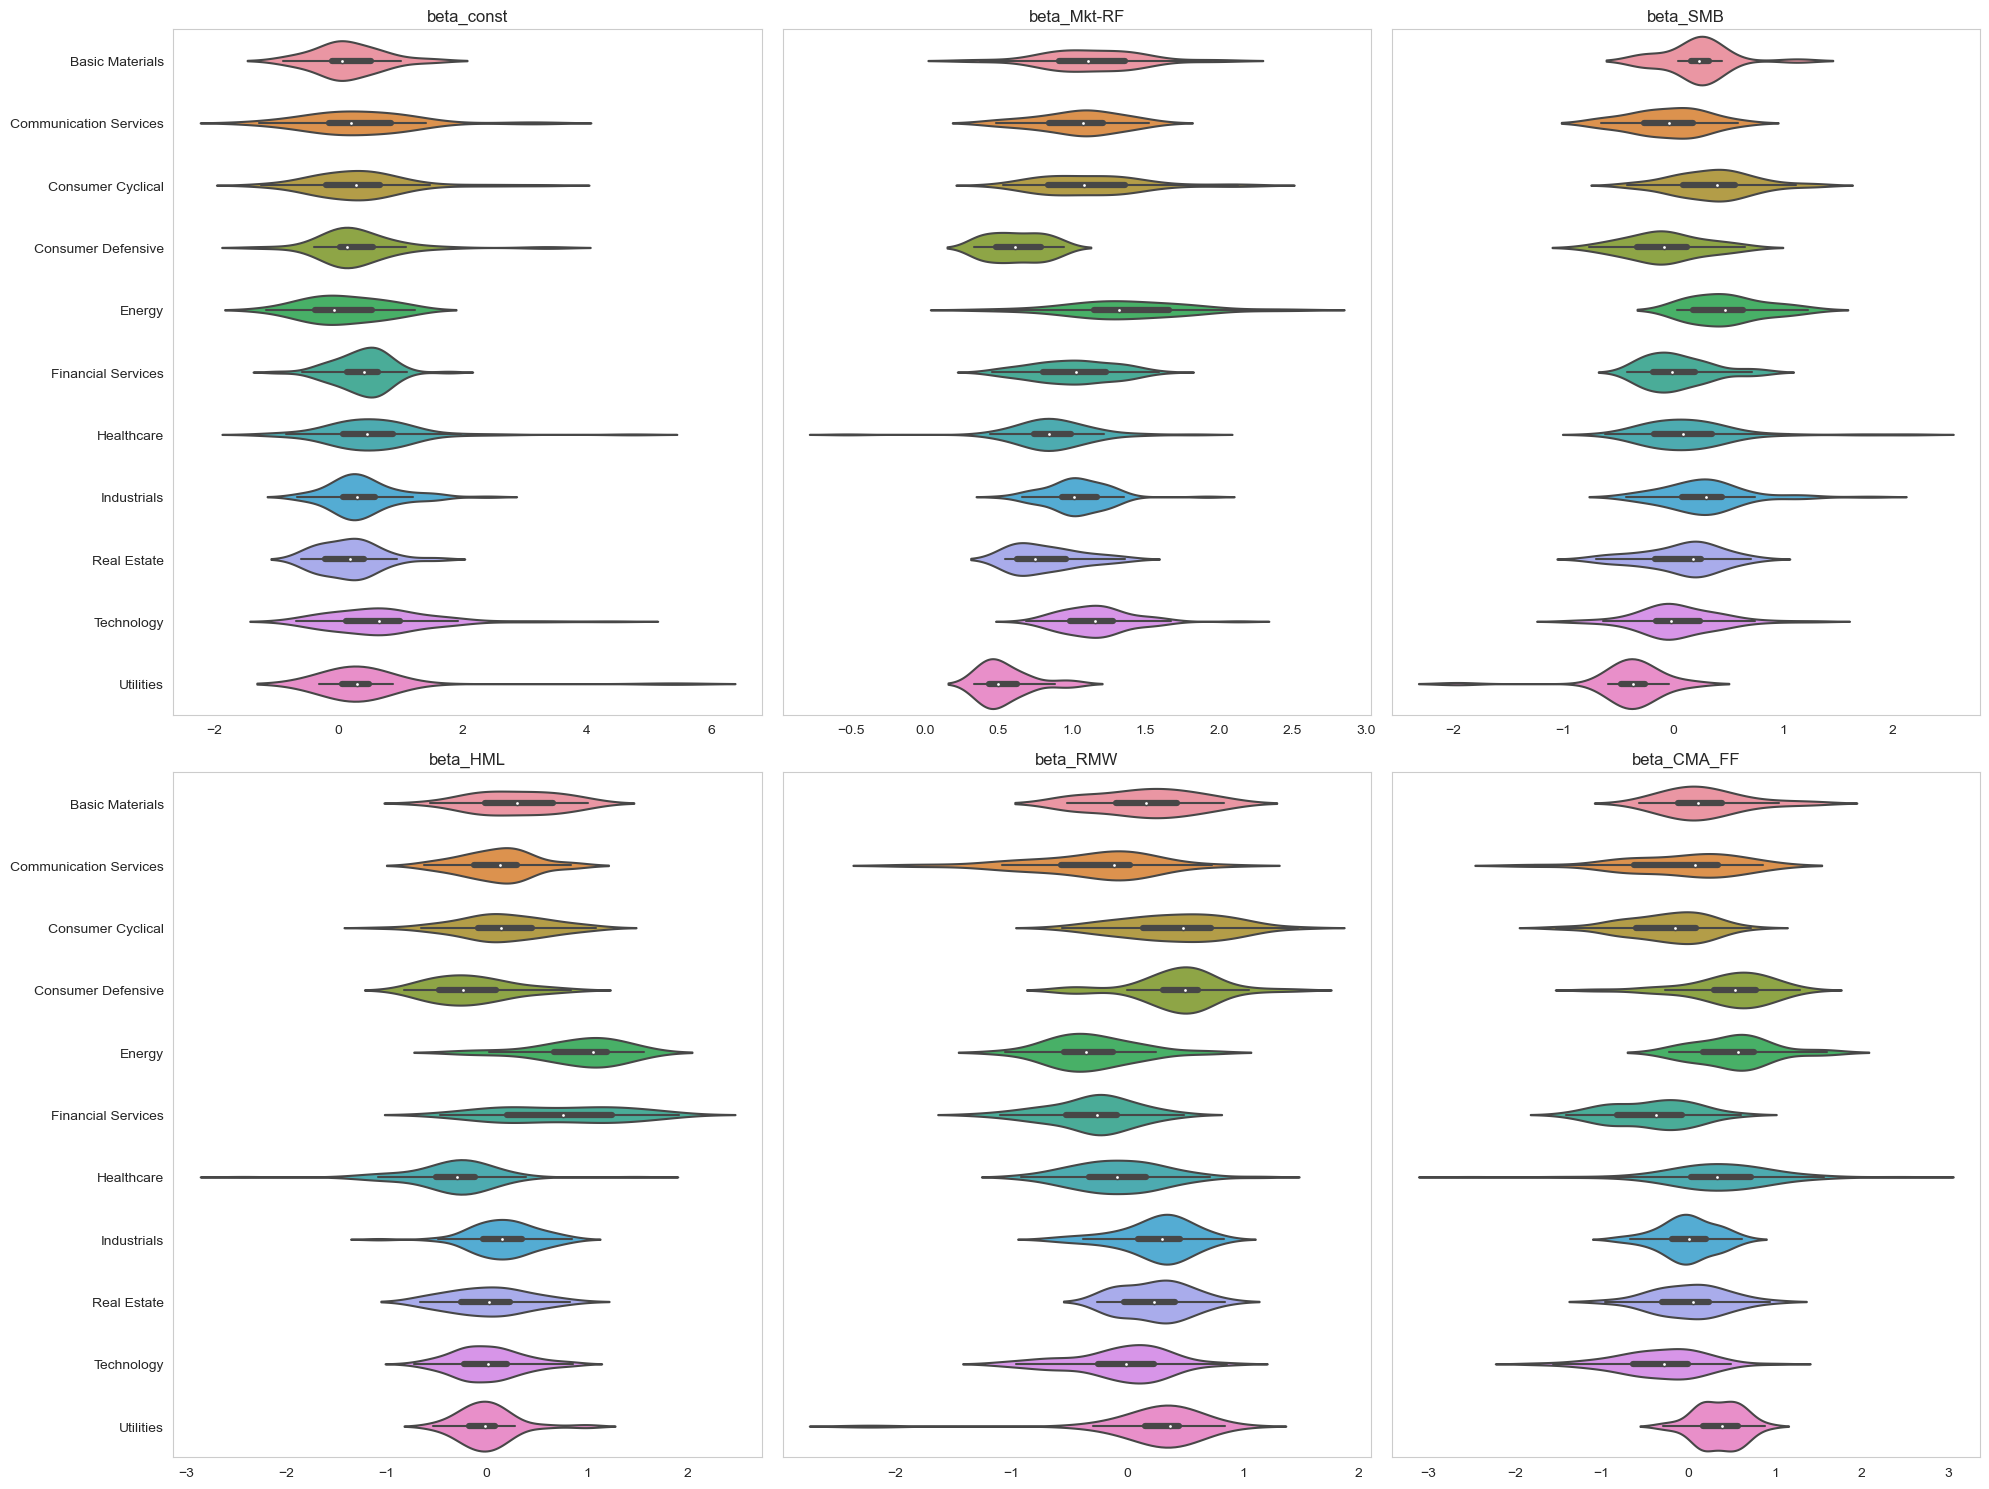

In [101]:
plot_violin_sector(df_results_sectors_monthly)

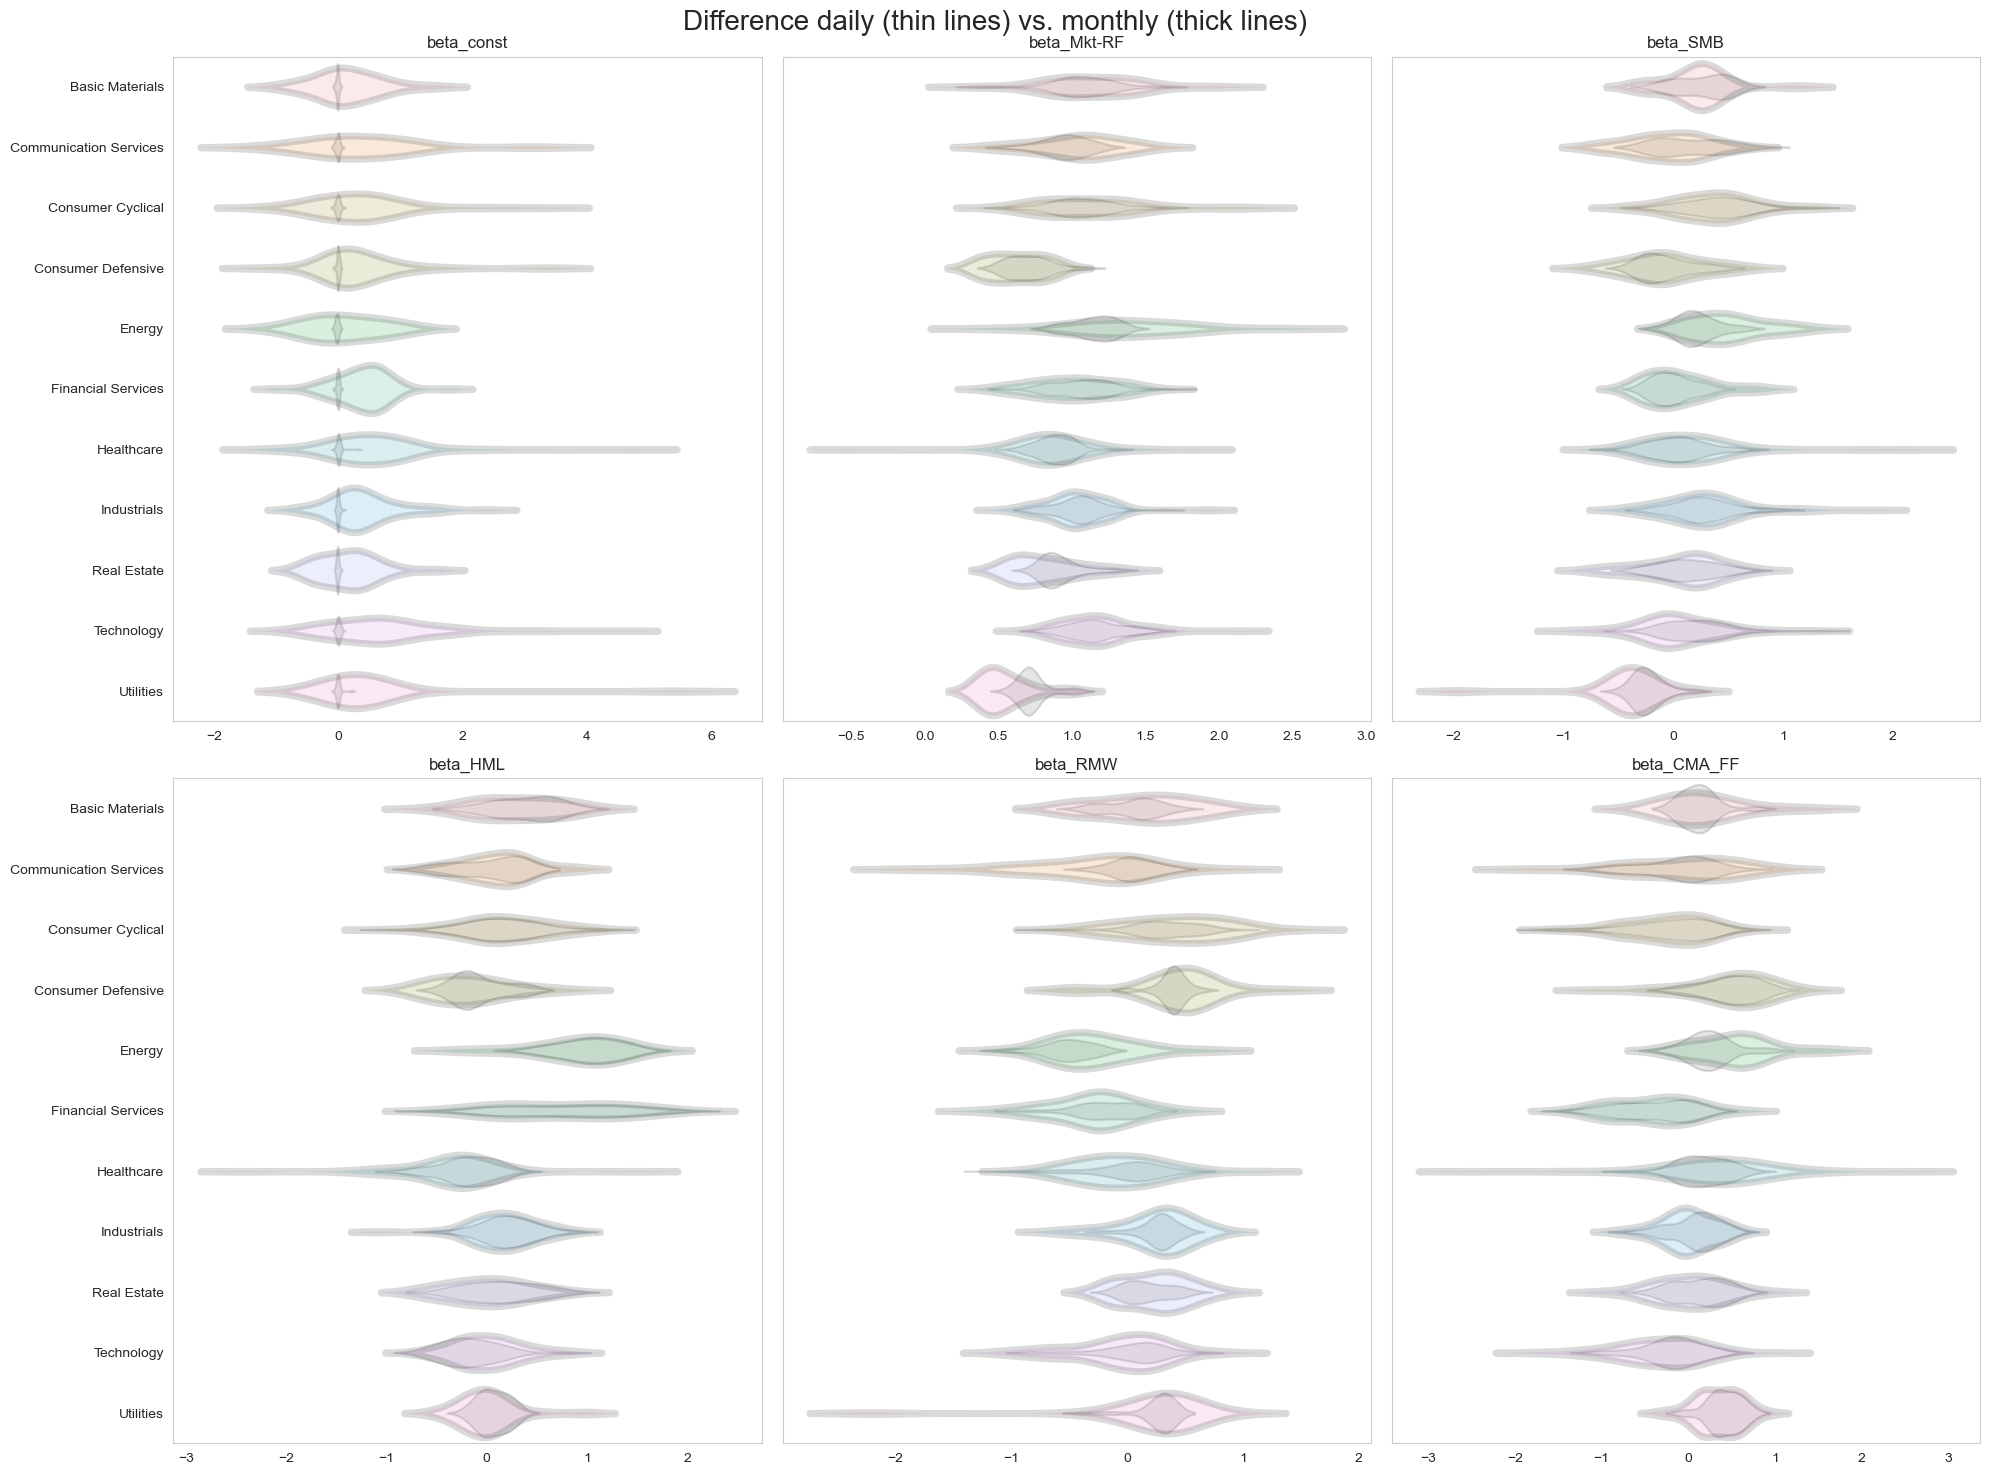

In [204]:
plot_violin_sector(df_results_sector, df_results_sectors_monthly)

## 7.5 Monthly clustering
Here we will proceed in the same way as in the daily case: we compute clusters based on coefficients and t-statistics.

In [103]:
monthly_df_clustering_ff = prep_cluster_ff_coefs(df_ols_results_monthly)
monthly_df_clustering_ff

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF
A,0.294073,1.214892,-0.020409,-0.148430,-0.259647,0.045813,0.690306,12.152276,-0.105645,-0.853735,-1.110339,0.170848
AAL,0.374067,1.022034,1.218077,0.337466,0.492118,0.333777,0.359557,4.186176,2.581864,0.794812,0.861735,0.509688
AAP,0.007499,0.796971,0.751893,0.185199,1.075425,-0.069573,0.011994,5.431428,2.651759,0.725758,3.133317,-0.176771
AAPL,0.958511,1.151640,-0.162278,-0.469033,0.768141,-0.257709,1.975232,10.112796,-0.737431,-2.368322,2.883687,-0.843686
ABBV,0.891144,0.802788,0.146737,-0.134273,0.158768,0.611667,1.389375,5.095952,0.506352,-0.533184,0.437334,1.566199
...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.279013,0.819716,0.210830,0.026693,1.000235,-0.115702,0.671013,8.400491,1.118097,0.157297,4.382238,-0.442057
ZBH,-0.171948,1.000043,-0.089467,0.016064,-0.467143,0.409826,-0.394960,9.788310,-0.453169,0.090410,-1.954753,1.495496
ZBRA,0.798684,1.283209,0.741254,0.104372,0.274844,-1.147650,1.342329,9.189985,2.747204,0.429817,0.841505,-3.064241
ZION,0.289053,1.059372,0.832311,1.595469,-0.768070,-0.985006,0.658653,10.286355,4.182200,8.908071,-3.188351,-3.565726


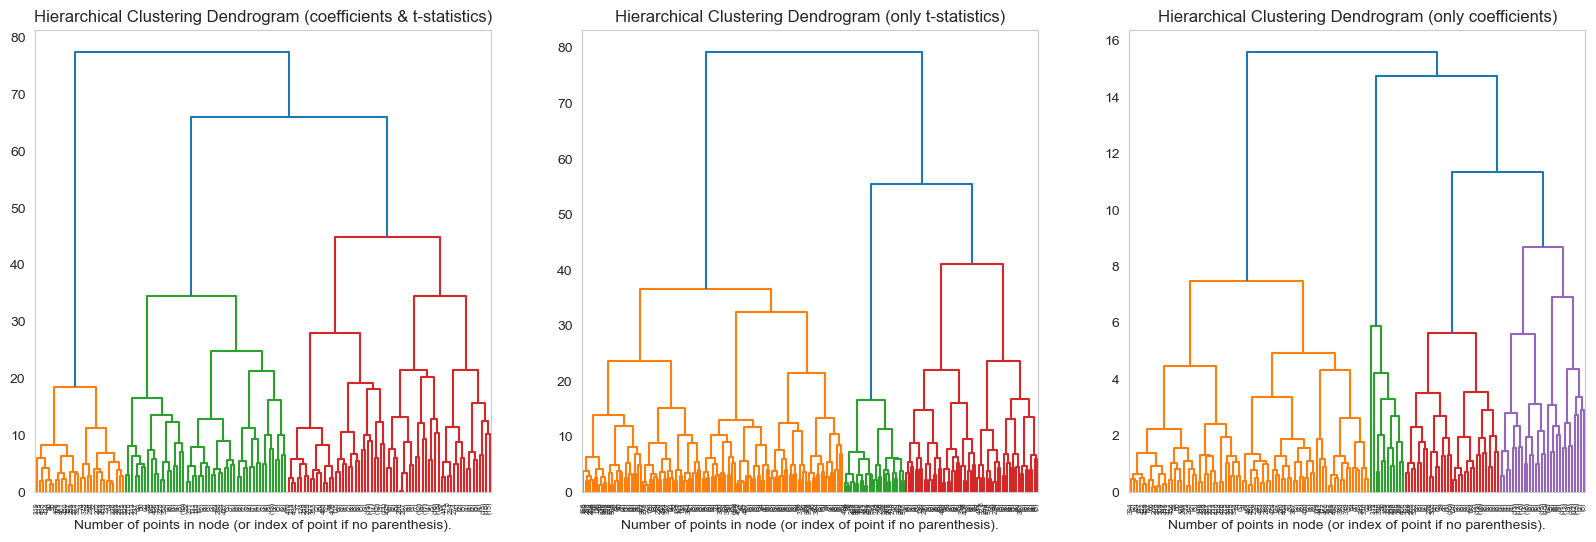

In [205]:
plot_dendrogram_ff(df_ols_results_monthly, p = 7)

In [209]:
df_ff_clustering_monthly = df_ols_results_monthly.iloc[:,1:].copy()

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=4)

model = model.fit(df_ff_clustering_monthly)

df_clustering_result_monthly = df_ols_results.copy()
df_clustering_result_monthly["cluster"] = model.labels_
df_clustering_result_monthly = df_clustering_result_monthly.set_index("stock")

In [210]:
df_clustering_result_monthly.groupby("cluster").mean()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
cluster,,,,,,,,,,,,,
0,-0.009006,1.119689,0.202898,0.318908,0.085937,-0.045512,-0.298723,51.189251,3.874690,6.728838,2.177679,-0.306578,0.521146
1,0.018621,0.836521,-0.027859,-0.190451,0.027006,0.257287,0.340559,32.115059,-2.306406,-3.521114,2.248786,4.292160,0.297638
2,-0.011542,1.172457,0.040160,1.336402,-0.368429,-0.738741,-0.578778,64.269656,0.672170,40.352287,-7.922757,-11.408977,0.713383
3,-0.004081,0.974607,0.194370,0.112906,0.184570,0.007708,-0.085818,39.440966,3.234824,2.297247,3.281162,0.570317,0.395205


## 7.6 Monthly constants

In [111]:
print_top_bottom_5(df_ols_results)

############## Top 5 Companies ###############
1. GE HealthCare Technologies Inc. (alpha:  0.325)
2. Constellation Energy Corporation (alpha:  0.221)
3. Moderna, Inc. (alpha:  0.177)
4. Tesla, Inc. (alpha:  0.093)
5. Carrier Global Corporation (alpha:  0.093)
############ Bottom 5 Companies ##############
496. WestRock Company (alpha: -0.078)
497. APA Corporation (alpha: -0.080)
498. Carnival Corporation & plc (alpha: -0.081)
499. DISH Network Corporation (alpha: -0.082)
500. Norwegian Cruise Line Holdings Ltd. (alpha: -0.087)


In [110]:
print_top_bottom_5(df_ols_results_monthly)

############## Top 5 Companies ###############
1. Constellation Energy Corporation (alpha:  5.381)
2. Moderna, Inc. (alpha:  4.733)
3. Enphase Energy, Inc. (alpha:  4.388)
4. SolarEdge Technologies, Inc. (alpha:  3.394)
5. Keurig Dr Pepper Inc. (alpha:  3.354)
############ Bottom 5 Companies ##############
496. Viatris Inc. (alpha: -1.157)
497. APA Corporation (alpha: -1.159)
498. The Kraft Heinz Company (alpha: -1.174)
499. Carnival Corporation & plc (alpha: -1.247)
500. DISH Network Corporation (alpha: -1.271)


## Comments:

# 8. As in the first question, estimate the daily data regressions but with left hand side variable $r^i_{t+1} − R^f_{t + 1}$ , that is one day ahead returns. How different are the results?

In [140]:
X = prepare_data_ols(df)
X

,const,Mkt-RF,SMB,HML,RMW,CMA_FF
0,1.0,1.69,0.79,1.13,-0.17,0.21
1,1.0,0.31,-0.41,1.24,-0.19,0.19
2,1.0,0.13,-0.13,0.57,-0.05,0.20
3,1.0,0.40,0.25,0.98,-0.69,0.22
4,1.0,0.33,0.32,0.01,0.22,-0.37
...,...,...,...,...,...,...
3329,1.0,0.27,0.51,1.02,-0.28,0.35
3330,1.0,-0.17,-0.03,0.74,0.08,0.55
3331,1.0,1.39,-0.34,-0.50,-0.90,-0.54
3332,1.0,0.51,-0.61,-0.59,0.20,-0.09


In [151]:
df_ols_results.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.001073,0.999385,0.140291,0.177697,0.089978,0.003850,-0.085198,42.773462,2.086370,4.501041,2.099705,0.440326,0.429731
std,0.033113,0.216041,0.299822,0.498204,0.324844,0.426940,0.924686,12.759200,6.125506,12.265380,5.324235,5.450606,0.134704
min,-0.086930,0.440068,-0.548381,-0.920035,-1.137032,-1.556368,-2.743255,2.348171,-15.501211,-16.779481,-19.895185,-17.911638,0.058644
25%,-0.016873,0.847333,-0.097875,-0.164749,-0.062508,-0.215519,-0.698177,34.721995,-2.327988,-4.124568,-1.062616,-2.495663,0.331105
50%,-0.001784,1.001999,0.109269,0.097894,0.148759,0.059204,-0.079938,41.245214,2.524024,2.320290,2.278885,0.685821,0.426387
75%,0.012642,1.146461,0.336663,0.388927,0.324796,0.290818,0.532678,50.602802,6.652103,8.613377,6.168719,3.649556,0.522387
max,0.324966,1.675626,1.357604,1.807276,0.888306,0.971784,2.458251,83.367639,17.323145,52.439310,14.599549,14.323287,0.783297


In [150]:
df_ols_results_forecast = ols_estimation(df, X, returns, forecast=True)
df_ols_results_forecast.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.054155,-0.115475,0.126737,-0.075649,0.042767,-0.040036,1.629407,-3.711335,1.990512,-1.328474,0.515922,-0.247357,0.008658
std,0.033147,0.067125,0.089869,0.071702,0.087355,0.151226,0.839244,1.778812,1.131827,0.978632,0.900608,1.007840,0.006218
min,-0.077382,-0.372399,-0.409777,-0.975078,-0.424052,-0.652557,-0.722259,-8.881212,-1.781546,-4.324454,-3.091309,-3.178306,0.000703
25%,0.035351,-0.149967,0.069650,-0.111034,-0.004872,-0.101867,1.059158,-4.930979,1.261398,-1.982846,-0.066836,-0.884052,0.004598
50%,0.052496,-0.111922,0.121328,-0.074410,0.044498,-0.021900,1.685304,-3.692336,2.066282,-1.317234,0.557090,-0.223339,0.007463
75%,0.070651,-0.078777,0.173012,-0.037204,0.084384,0.042256,2.188638,-2.559388,2.754318,-0.657120,1.085891,0.433855,0.010934
max,0.367326,0.470720,0.507069,0.281095,0.596330,1.372113,3.643724,3.153701,5.412208,1.588884,4.353520,2.302881,0.082047


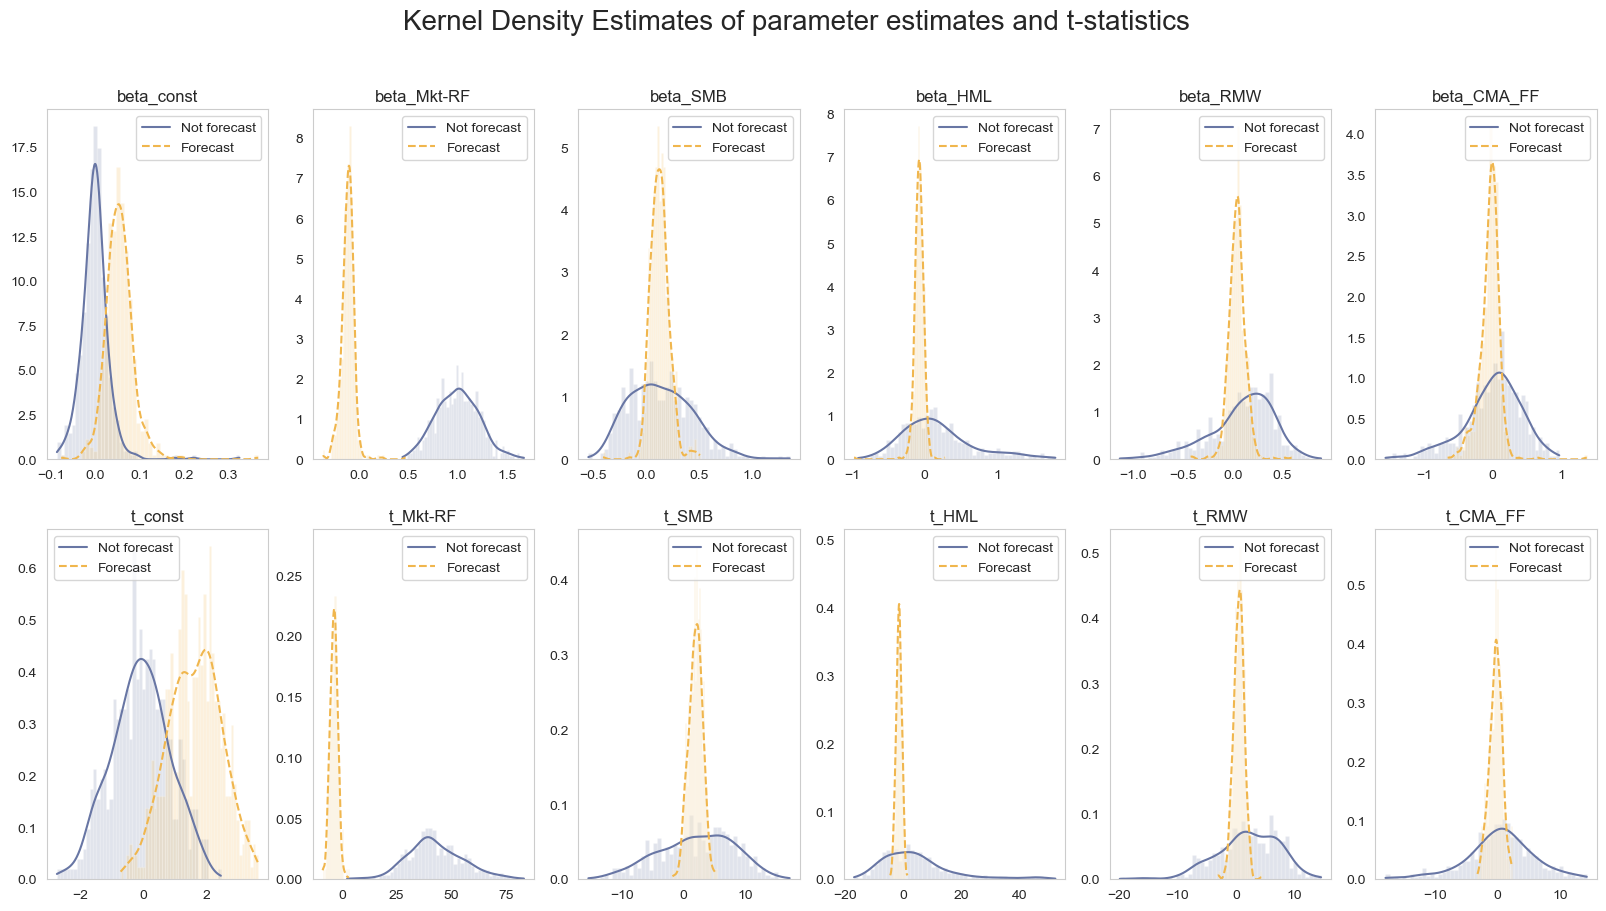

In [156]:
kde_statistics(df_ols_results, df_ols_results_forecast, label1="Not forecast", label2 = "Forecast")

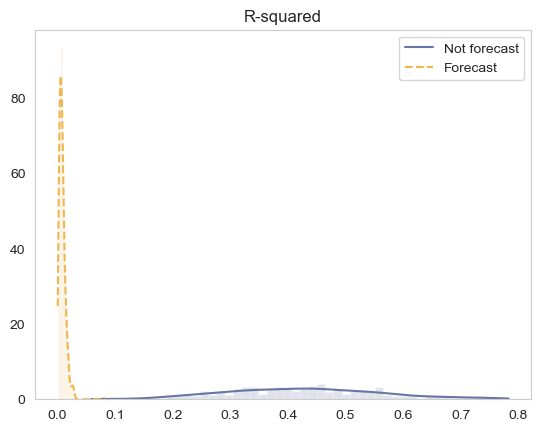

In [158]:
plot_r_squared(df_ols_results, df_ols_results_forecast, label1="Not forecast", label2 = "Forecast" )

**Comment:** The most considerable difference between the two cases is in the R-squared, which captures the expressive power of the regressors. We observe that while before we had 40-50% of variation that was explained by the five FF factors, but once we try to forecast, this goes down to almost 0. This means that the FF factors are able to forecast returns, but predicting is a whole other story.